In [1]:
# Install required packages
%pip install -q numpy matplotlib torch pytorch_tabular scikit-learn
%reset -f

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import required packages
import os

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
)
from pytorch_tabular.models.common.heads import LinearHeadConfig

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
datafile = "~/Downloads/csd.csv"
df = pd.read_csv(datafile)

df_trimmed = df.loc[:, ~df.columns.isin(['feature', 'grade', 'stage'])] 
df_trimmed.head()

,age,gender,OS_vital_status,CNV_20q,CNV_20p,CNV_Xq11.2,CNV_14q,CNV_17q24.3,CNV_7q36.3,CNV_12p,...,mRNA_PMS2L2|5380,mRNA_LRRC69|100130742,mRNA_GALNT4|8693,mRNA_OR11H12|440153,mRNA_C12orf50|160419,mRNA_TP53TG5|27296,mRNA_WDR48|57599,mRNA_UNC93A|54346,mRNA_ZNF20|7568,mRNA_PRR24|255783
0,54,FEMALE,1,0.000,0.000,-0.052984,-0.382,0.018996,0.003521,0.000,...,18.8615,1.4509,545.7878,0.0000,0.3627,0.6674,611.9120,8.7053,109.5203,286.5504
1,63,FEMALE,0,0.000,0.000,-0.029994,0.000,-0.010951,-0.000970,0.000,...,40.5490,0.8507,514.2375,0.0000,0.2836,0.8819,568.5363,132.1386,74.8341,72.8747
2,54,MALE,0,0.000,0.000,-0.010232,0.000,0.002358,-0.000416,0.000,...,22.5615,0.0000,460.2424,0.0000,0.3772,0.0000,806.8737,39.6081,101.9928,267.8262
3,65,MALE,1,0.000,0.000,-0.098945,-0.500,0.008892,0.066372,0.000,...,44.7036,1.9436,630.3401,0.0000,0.0000,0.0000,856.8189,5.1830,135.7953,129.5756
4,57,MALE,0,0.455,0.455,0.007262,0.000,0.002080,0.447990,0.438,...,46.1332,1.5268,665.6661,0.4325,0.4325,0.0000,767.3010,3.0277,112.4308,127.5952


In [4]:
df_trimmed['OS_vital_status'].value_counts()

OS_vital_status
0    153
1     90
Name: count, dtype: int64

In [5]:
target_name = ["OS_vital_status"]
cat_col_names = ["gender"]
col_names = list(df.columns)
num_col_names = col_names[7:]
num_col_names.insert(0, "age")
feature_columns = num_col_names + cat_col_names + target_name

In [6]:
# Train/Test Split
train, test = train_test_split(df_trimmed, random_state = 42, test_size = 0.25)
train2, val = train_test_split(train, random_state = 42, test_size = 0.25)

num_classes = len(set(train[target_name].values.ravel()))

In [17]:
test.shape

(61, 16379)

In [7]:
print(train.shape)
print(test.shape)
print(val.shape)

(136, 16379)
(61, 16379)
(46, 16379)


In [8]:
data_config = DataConfig(
    target = target_name,
    continuous_cols = num_col_names,
    categorical_cols = cat_col_names,
    continuous_feature_transform = None, 
    normalize_continuous_features = True
)

In [9]:
head_config = LinearHeadConfig(
    layers = "", dropout = 0.1, initialization = "kaiming" 
).__dict__  

In [10]:
model_config = CategoryEmbeddingModelConfig(
    task = "classification",
    metrics = ["f1_score", "accuracy"],
    metrics_params = [{"num_classes": num_classes}, {}],
    metrics_prob_input = [True, False],
)

In [11]:
trainer_config = TrainerConfig(auto_lr_find = True, fast_dev_run = False, max_epochs = 100, batch_size = 16)
optimizer_config = OptimizerConfig()
tabular_model = TabularModel(
    data_config = data_config,
    model_config = model_config,
    optimizer_config = optimizer_config,
    trainer_config = trainer_config,
)

2024-03-18 11:08:46,097 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

In [12]:
tabular_model.fit(
    train = train,
    validation = val,
)

Seed set to 42


2024-03-18 11:08:46,530 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-03-18 11:08:46,535 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
classification task

2024-03-18 11:08:47,051 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: CategoryEmbeddingModel

2024-03-18 11:08:48,306 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-03-18 11:08:48,363 - {pytorch_tabular.tabular_model:630} - INFO - Auto LR Find Started

/Users/sohashahidi/DATASCI 223/datasci223_finalproj/venv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/sohashahidi/DATASCI 223/datasci223_finalproj/saved_models exists and is not empty.
/Users/sohashahidi/DATASCI 223/datasci223_finalproj/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/sohashahidi/DATASCI 223/datasci223_finalproj/venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/Users/sohashahidi/DATASCI 223/datasci223_finalproj/venv/lib/python3.11/site-packages

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 82 steps due to diverging loss.
Learning rate set to 6.918309709189363e-05
Restoring states from the checkpoint path at /Users/sohashahidi/DATASCI 223/datasci223_finalproj/.lr_find_fb3e1f5a-c3d6-486b-976e-e1419ab3c6b1.ckpt
Restored all states from the checkpoint at /Users/sohashahidi/DATASCI 223/datasci223_finalproj/.lr_find_fb3e1f5a-c3d6-486b-976e-e1419ab3c6b1.ckpt


2024-03-18 11:08:59,733 - {pytorch_tabular.tabular_model:643} - INFO - Suggested LR: 6.918309709189363e-05. For    
plot and detailed analysis, use `find_learning_rate` method.

2024-03-18 11:08:59,746 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │  2.1 M │
│ 1 │ _embedding_layer │ Embedding1dLayer          │ 32.8 K │
│ 2 │ head             │ LinearHead                │     66 │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │
└───┴──────────────────┴───────────────────────────┴────────┘

Trainable params: 2.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.1 M                                                                                                
Total estimated model params size (MB): 8

Output()

2024-03-18 11:09:05,137 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-03-18 11:09:05,139 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

In [13]:
pred_df = tabular_model.predict(test)

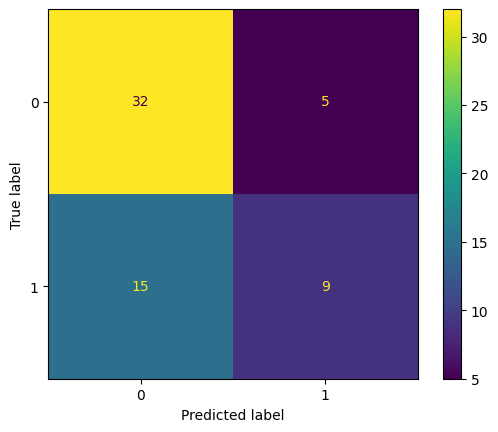

In [14]:
cm = confusion_matrix(test['OS_vital_status'], pred_df['prediction'])
ConfusionMatrixDisplay.from_predictions(test['OS_vital_status'], pred_df['prediction'])

In [15]:
acc = accuracy_score(test['OS_vital_status'], pred_df['prediction'])
precision = cm[0,0]/(cm[0,0]+cm[0,1])
recall = cm[0,0]/(cm[0,0]+cm[1,0])
f1 = 2/((1/precision) + (1/recall))

print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6721311475409836
Precision: 0.8648648648648649
Recall: 0.6808510638297872
F1 Score: 0.7619047619047619


In [16]:
print(classification_report(test['OS_vital_status'], pred_df['prediction'], target_names = ['Alive', 'Died']))

              precision    recall  f1-score   support

       Alive       0.68      0.86      0.76        37
        Died       0.64      0.38      0.47        24

    accuracy                           0.67        61
   macro avg       0.66      0.62      0.62        61
weighted avg       0.67      0.67      0.65        61

